# An initial training pipeline

In [1]:
# restart kernel to hav e a fresh slate
%load_ext dotenv
%dotenv ../src/.env
import sys
sys.path.append("../src")
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob
# ft_dir = os.getenv("FEATURES_DATA")
ft_dir = os.getenv("PRICE_DATA")
ft_glob = glob(os.path.join(ft_dir+'*/*/*.parquet'))
# ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [2]:
df['Close']

0          51.502148
1          47.567955
2          44.617310
3          42.918453
4          46.494991
             ...    
2712063    38.419998
2712064    38.680000
2712065    38.080002
2712066    39.430000
2712067    38.770000
Name: Close, Length: 2712068, dtype: float64

In [4]:
price = df[['Close']].dropna()
# price.describe()
price.values

array([[51.50214767],
       [47.56795502],
       [44.61730957],
       ...,
       [38.08000183],
       [39.43000031],
       [38.77000046]])

In [6]:
# we want to apply standard transformation

# the data we have comes in raw form, we may want to apply different set of transformation
# put them together in a pipeline
# can't do it with pandas, need to use scikit 

# FEATURE_DATA isn't available so edited this command
#returns = df[['log_returns', 'returns']].dropna()
returns = df[['Close']].dropna()
returns.describe()

,Close
count,2.712068e+06
mean,7.766873e+01
std,1.643895e+02
min,3.052100e-02
25%,2.360000e+01
50%,4.362000e+01
75%,8.101000e+01
max,7.687100e+03


In [7]:
# Create a StandardScaler object
# a function to allow me to scale my data
# load function, create standard scalar object
# can apply functions to what it is I wan t to apply


from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
# the mean and stardard deviation will be calculated
# parameters will be learn, filter
# after scalar, we will run mean
std_scaler.fit(price)


StandardScaler()

In [8]:
std_scaler.fit(price)


StandardScaler()

In [9]:
std_scaler.mean_


array([77.66873437])

In [10]:
std_scaler.transform(price)

array([[-0.15917435],
       [-0.18310649],
       [-0.20105561],
       ...,
       [-0.2408228 ],
       [-0.23261061],
       [-0.23662546]])

In [11]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

,Close
count,2.712068e+06
mean,2.614690e-18
std,1.000000e+00
min,-4.722822e-01
25%,-3.289063e-01
50%,-2.071224e-01
75%,2.032532e-02
max,4.628904e+01


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='sector'>

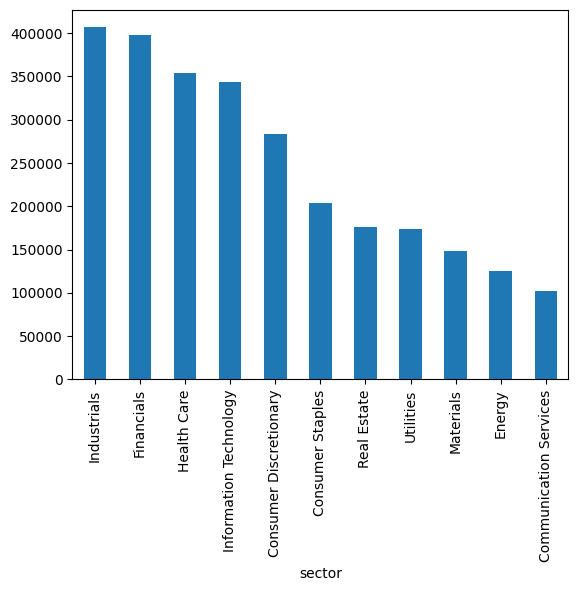

In [12]:
df['sector'].value_counts().plot(kind = 'bar')

In [13]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year
0,A,2000-01-03,56.330471,56.464592,48.193848,51.502148,43.683865,4674353,Health Care,Life Sciences Tools & Services,2000
1,A,2000-01-04,48.730328,49.266811,46.316166,47.567955,40.346905,4765083,Health Care,Life Sciences Tools & Services,2000
2,A,2000-01-05,47.389126,47.567955,43.141991,44.617310,37.844181,5758642,Health Care,Life Sciences Tools & Services,2000
3,A,2000-01-06,44.080830,44.349072,41.577251,42.918453,36.403217,2534434,Health Care,Life Sciences Tools & Services,2000
4,A,2000-01-07,42.247852,47.165592,42.203148,46.494991,39.436810,2819626,Health Care,Life Sciences Tools & Services,2000
...,...,...,...,...,...,...,...,...,...,...,...
2712063,ZION,2024-02-26,38.610001,39.439999,38.040001,38.419998,38.419998,2030500,Financials,Regional Banks,2024
2712064,ZION,2024-02-27,38.860001,39.240002,38.340000,38.680000,38.680000,1786000,Financials,Regional Banks,2024
2712065,ZION,2024-02-28,38.290001,38.689999,38.009998,38.080002,38.080002,1487000,Financials,Regional Banks,2024
2712066,ZION,2024-02-29,39.180000,39.630001,38.750000,39.430000,39.430000,2991100,Financials,Regional Banks,2024


+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [14]:
# load transform
# create transformer object
# fit withdata
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['sector']])

OneHotEncoder()

In [15]:
# apply transformation publish_display_data
# then display it
sector_enc = onehot.transform(df[['sector']])
sector_enc.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [16]:
# we want to concatonate them.
# Have a dataset that contains both catagorial and numerical variables.
# I want to direct my algorithm to apply certain methods to my numerical variables and 
# certain other methods too my categorial variables.


# 
# First step is to load a pipeline
from sklearn.pipeline import Pipeline
# Second, I am loading standard scaler
from sklearn.preprocessing import StandardScaler
# Decision Tree Classifiation method
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [17]:
# Essentially what the Pipeline method does is that it will take a list, 
# which contain steps; pay attention to the [List]
# Steps are defined by Tuples; (Tuples)

# hotcold transfromer
# used to handle unknown data
# this this case ignore, don't clasify
# you through in data, it will apply encoder and apply decision tree
pipe1 = Pipeline(
    [
        # tuple has a name I give, contains one step; then give it a certain tranform 'OneHotEncoder'
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        # second step, decisiontree
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
# creating something that is a sequencial application of steps
# What the pipeline is telling me is that I can put in some data and it will apply
# OneHotEncoder and then apply DecisionTreeClassifier
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [18]:
# need to define our X Y data set
# x contains all of our features, in this case I only want one feature 'sector'
# on other side I will have one 'target'
# train test split will take random stratefied sample of data and be stratisfied by the 
# labels in the in the response variable 'target'
# can specify how much we want to keep in our testing side '0.2' and how much to keep on training side '0.8'
# 80 to 20 percent split
# I can fix my random state, will ensure everyone gets the same results; no meaning
# Only thing to keep in mind is that if you fix your random state, you need to publish it
# The return is a set of training and testing features and target variables 'X0_train, X0_test, Y0_train, Y0_test'
# Then we can fit a pipeline. This works exactly like the transforms.
# But now contains hot and cold and decision tree classifier.
# Now we have a chance to train and predict using the entire pipeline; within taht pipeline we can get our training
X0 = df[['sector']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

KeyError: 'target'

In [ ]:
# contains the actuall predictions
# provide a actual reditions of what was predicted
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [ ]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [ ]:
# if i want to extract actual predictions, 
# this will giv ea probablilty assessement
# if want to use probabilities, we need to take 
# taking each one of our results and compare them
# getting them from myt metics library
# "from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score" 
# assess accruacy with "'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train)"
# 
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [ ]:
# need to split numerical and catagorigal transformation
# like a pipeline one after the other; single
# catagorial splits the decision; parallel
from sklearn.compose import ColumnTransformer

In [ ]:
# tuple, given 3 names
# then we have a step
# thenwe have the variables
# then apply a one hot transformation to "sector", defining which 'r' 
#
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(), ['sector']), 
    ], remainder='drop'
)

# finally create pipeline
# put in first step of pipeline
# decision tree is second step
# transformer will first split decisions
# then apply classification algorithm at the end
# this is how we create model transformion pipeline
# MOST IMPORTANT BIT WE COVERED
pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

In [ ]:
pipe

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

### Over fitting the enemy of generalization.

![](./img/train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [ ]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [ ]:
# Schema
X = df[['returns', 'Volume', 'sector']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [ ]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

In [ ]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./img/grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [ ]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [ ]:
pd.DataFrame(d3_dict)

In [ ]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [ ]:
pd.DataFrame(d15_dict).mean()